This notebook produces the figures of the paper ... using the smaller data-files created from the full experiments outputs thanks to the notebook [data_files](data_files.ipynb).

In [1]:
import os
import sys

import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cmocean.cm as cmo
import IPython
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [2]:
# Works in VS-Code only, hard-code it if necessary
nb_dir = "/".join(
    IPython.extract_module_locals()[1]["__vsc_ipynb_file__"].split("/")[:-1]
)
sys.path.append(os.path.dirname(nb_dir))

from domain import restrict_to_gulfstream

In [3]:
CM_TO_IN = 1 / 2.54
MAX_WIDTH = 17.5 * CM_TO_IN
MAX_HEIGHT = 20.5 * CM_TO_IN
DPI = 300

SMALL_FONT_SIZE = 8
MEDIUM_FONT_SIZE = 10
LARGE_FONT_SIZE = 12

plt.rc("font", size=SMALL_FONT_SIZE)
plt.rc("axes", titlesize=SMALL_FONT_SIZE)
plt.rc("axes", labelsize=SMALL_FONT_SIZE)
plt.rc("xtick", labelsize=SMALL_FONT_SIZE)
plt.rc("ytick", labelsize=SMALL_FONT_SIZE)
plt.rc("legend", fontsize=SMALL_FONT_SIZE)

HW_SPACE = .33 * CM_TO_IN


def get_gridspec_kwargs(fig_width: float, fig_height: float) -> dict:
    return dict(wspace=HW_SPACE / fig_width, hspace=HW_SPACE / fig_height)


CLB_AXIS_HW = 1.25 * CM_TO_IN
CLB_BAR_HW = .33 * CM_TO_IN
CLB_HW_SPACE = .33 * CM_TO_IN


def get_clb_kwargs(axes_width: float, axes_height: float, clb_location: str, clb_shrink: float) -> dict:
    if clb_location in ("bottom", "top"):
        axes_hw_fraction = axes_height
        axes_hw_aspect = axes_width
    else:
        axes_hw_fraction = axes_width
        axes_hw_aspect = axes_height
    
    fraction = CLB_AXIS_HW / axes_hw_fraction
    aspect = clb_shrink * axes_hw_aspect / CLB_BAR_HW
    pad = CLB_HW_SPACE / axes_hw_fraction

    return dict(location=clb_location, fraction=fraction, shrink=clb_shrink, aspect=aspect, pad=pad)


TITLE_H = .5 * CM_TO_IN

PLOT_NEUROST_GLOBAL_HW_RATIO = 206 / 496
PLOT_DUACS_GLOBAL_HW_RATIO = 248 / 496
PLOT_GS_HW_RATIO = 213.9 / 496

# Loading data-files

In [4]:
# CAN / SHOULD BE UPDATED TO REPRODUCE

DATA_FILES_PATH = f"{nb_dir}/data-files"
FIGURES_PATH = f"{nb_dir}/figures"

# Snapshot - Figures 1 & 2

In [5]:
neurost_snapshot = xr.open_dataset(f"{DATA_FILES_PATH}/neurost_snapshot.nc")
neurost_snapshot_zoom = restrict_to_gulfstream(neurost_snapshot)

In [6]:
UV_MAX = 1.5
NRV_MAX = .5

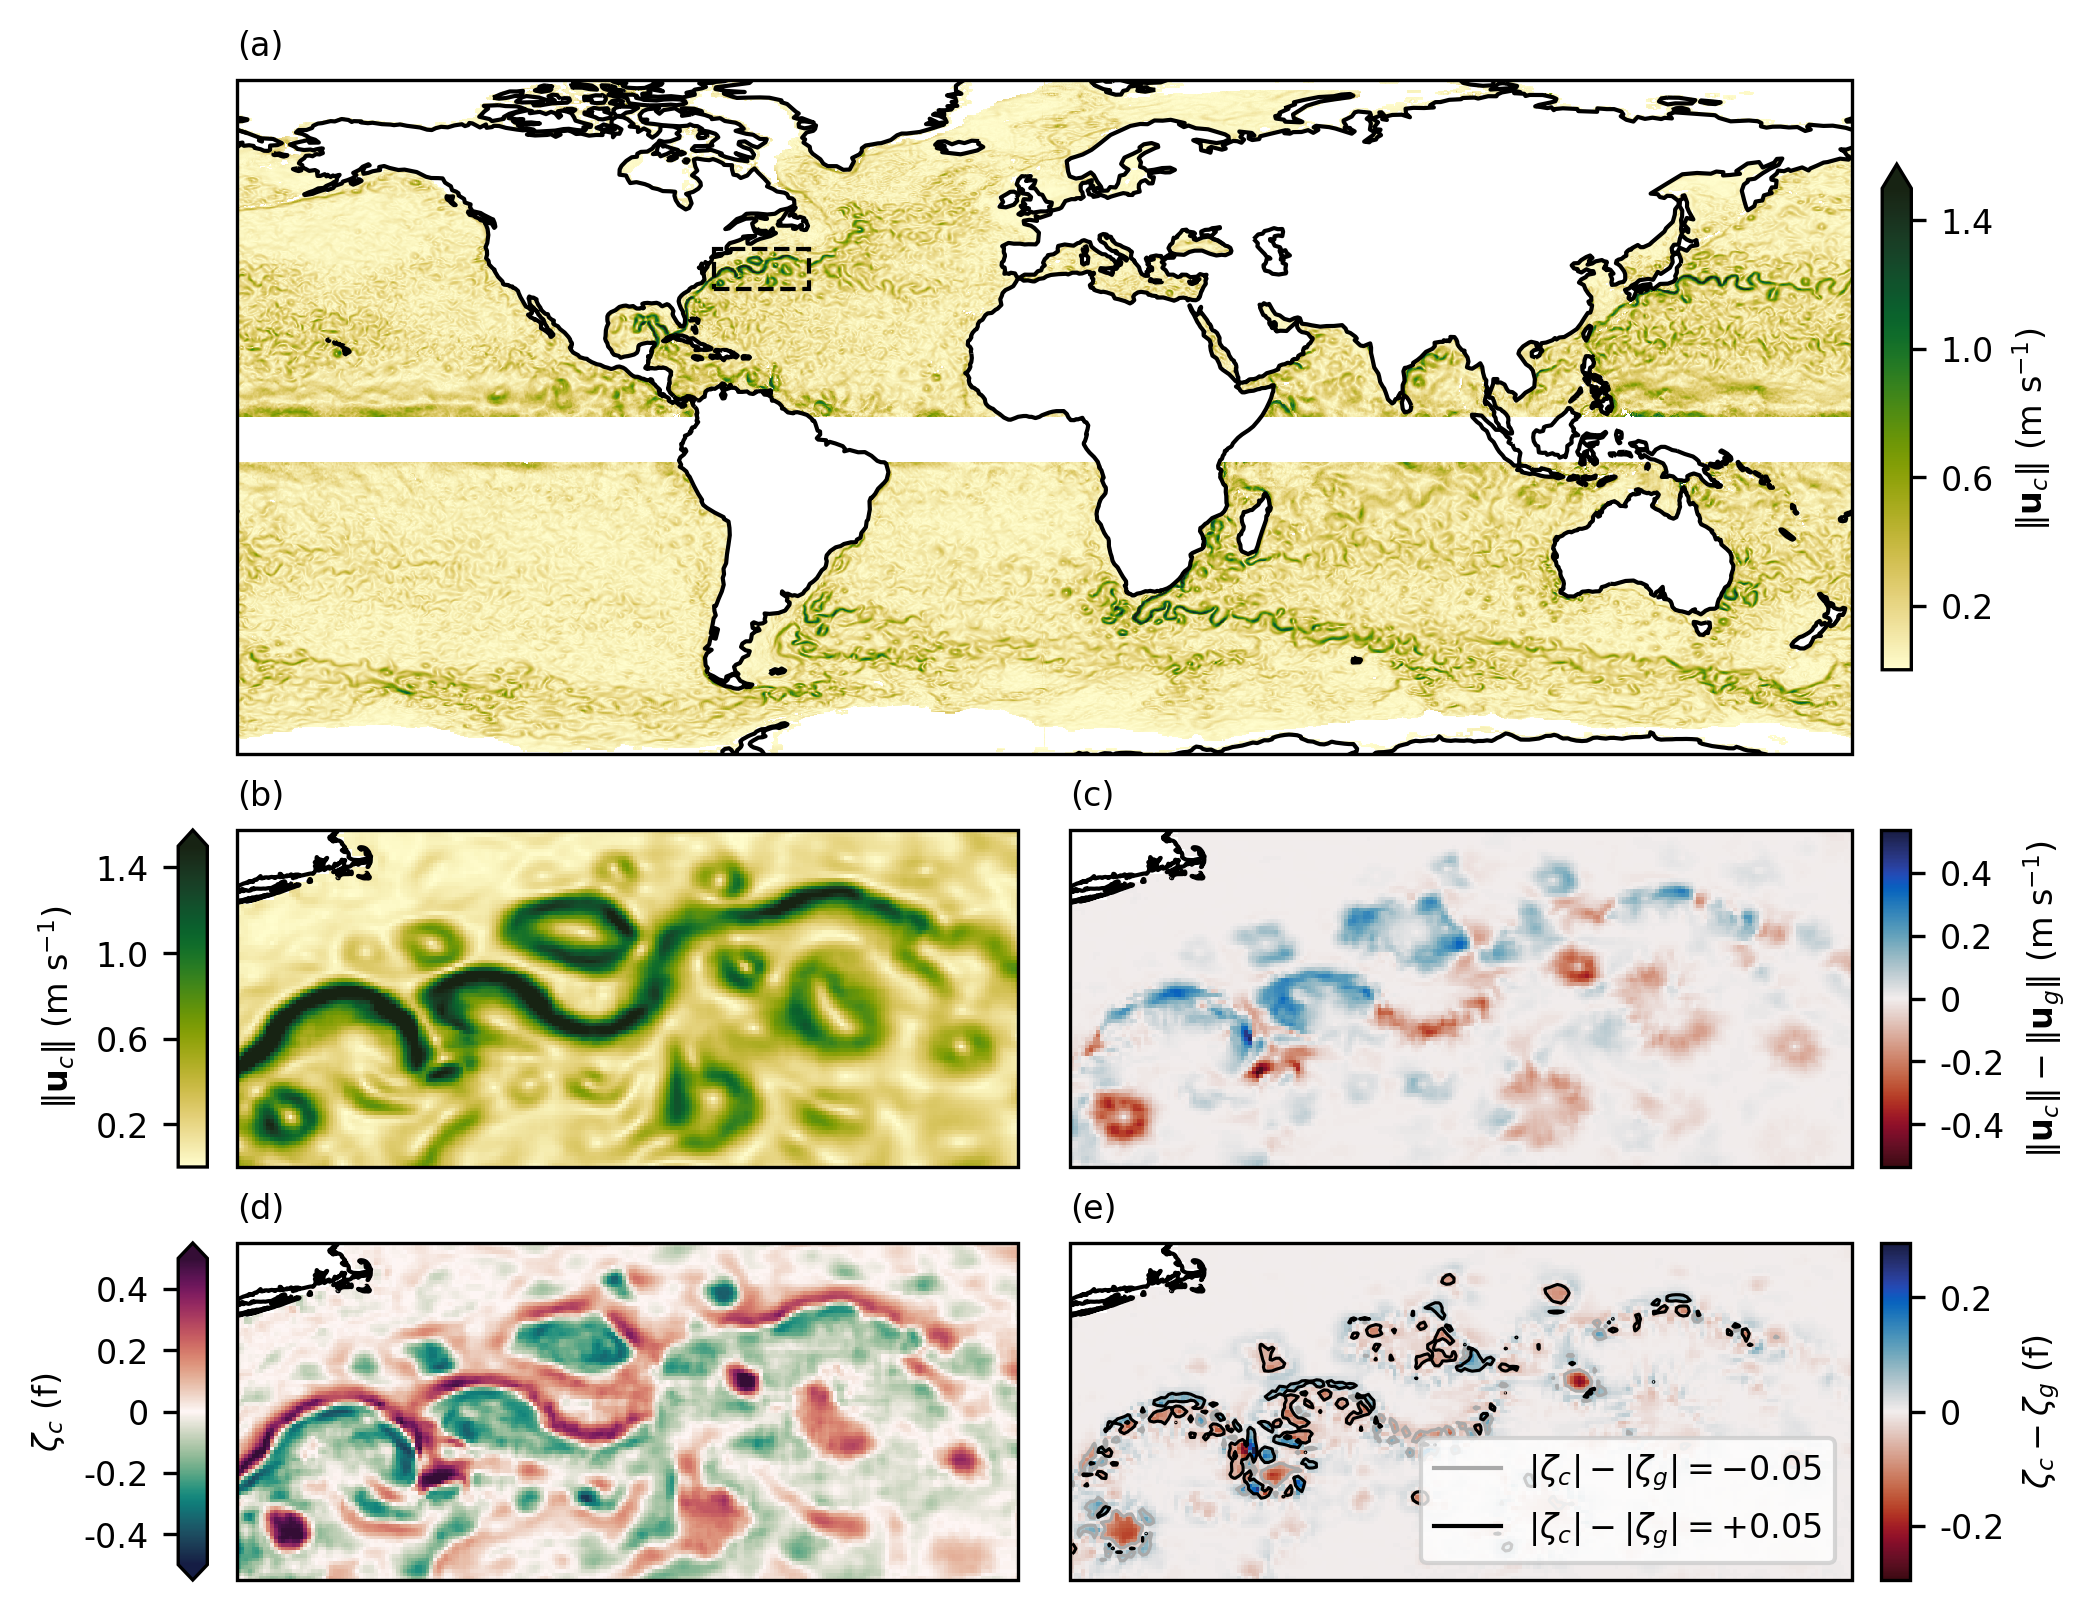

In [7]:
n_rows = 3
n_cols = 2
fig_width = MAX_WIDTH
fig_height = min(
    (
        ((fig_width - (CLB_AXIS_HW + CLB_HW_SPACE)) * PLOT_NEUROST_GLOBAL_HW_RATIO + TITLE_H) +
        (
            (
                fig_width - HW_SPACE * (n_cols - 1) - (CLB_AXIS_HW + CLB_HW_SPACE + TITLE_H)
            ) / n_cols * PLOT_GS_HW_RATIO + TITLE_H
        ) * (n_rows - 1) + 
        HW_SPACE * (n_rows - 1)
    ),
    MAX_HEIGHT
)

fig, axd = plt.subplot_mosaic(
    """
    AA
    BC
    DE
    """,
    height_ratios=[2, 1, 1],
    subplot_kw=dict(projection=ccrs.PlateCarree()),
    gridspec_kw=get_gridspec_kwargs(fig_width, fig_height),
    figsize=(fig_width, fig_height), dpi=DPI, layout="compressed"
)

im = axd["A"].pcolormesh(
    neurost_snapshot.longitude, neurost_snapshot.latitude, 
    neurost_snapshot.magn_Cyclogeostrophy,
    cmap=cmo.speed, vmin=0, vmax=UV_MAX,
    transform=ccrs.PlateCarree()
)
axd["A"].coastlines()
axd["A"].set_title("(a)", loc="left", fontsize=SMALL_FONT_SIZE)

axd["A"].add_patch(mpatches.Rectangle(
    xy=[neurost_snapshot_zoom.longitude.min(), neurost_snapshot_zoom.latitude.min()],
    width=neurost_snapshot_zoom.longitude.max() - neurost_snapshot_zoom.longitude.min(),
    height=neurost_snapshot_zoom.latitude.max() - neurost_snapshot_zoom.latitude.min(),
    linestyle="--", edgecolor="k", facecolor="none", linewidth=1
))

clb = fig.colorbar(
    im, ax=axd["A"],
    **get_clb_kwargs(fig_width, fig_height / 2, clb_location="right", clb_shrink=.75), 
    extend="max"
)
clb.set_label(label="$\| \mathbf{u}_c \|$ (m s$^{-1}$)", size=SMALL_FONT_SIZE)
tick_labels = [0.2, 0.6 , 1.0, 1.4]
clb.set_ticks(tick_labels)
clb.set_ticklabels(tick_labels, fontsize=SMALL_FONT_SIZE)

im = axd["B"].pcolormesh(
    neurost_snapshot_zoom.longitude, neurost_snapshot_zoom.latitude, 
    neurost_snapshot_zoom.magn_Cyclogeostrophy,
    cmap=cmo.speed, vmin=0, vmax=UV_MAX,
    transform=ccrs.PlateCarree()
)
axd["B"].coastlines()
axd["B"].set_title("(b)", loc="left", fontsize=SMALL_FONT_SIZE)

clb = fig.colorbar(
    im, ax=axd["B"],
    **get_clb_kwargs(fig_width / 2, fig_height / 4, clb_location="left", clb_shrink=1), 
    extend="max"
)
clb.set_label(label="$\| \mathbf{u}_c \|$ (m s$^{-1}$)", size=SMALL_FONT_SIZE)
tick_labels = [0.2, 0.6 , 1.0, 1.4]
clb.set_ticks(tick_labels)
clb.set_ticklabels(tick_labels, fontsize=SMALL_FONT_SIZE)

uv_diff = neurost_snapshot_zoom.magn_Cyclogeostrophy - neurost_snapshot_zoom.magn_Geostrophy
uv_diff_max = np.nanmax(np.abs(uv_diff))
im = axd["C"].pcolormesh(
    neurost_snapshot_zoom.longitude, neurost_snapshot_zoom.latitude, uv_diff,
    cmap=cmo.balance_r, vmin=-uv_diff_max, vmax=uv_diff_max,
    transform=ccrs.PlateCarree()
)
axd["C"].coastlines()
axd["C"].set_title("(c)", loc="left", fontsize=SMALL_FONT_SIZE)

clb = fig.colorbar(
    im, ax=axd["C"],
    **get_clb_kwargs(fig_width / 2, fig_height / 4, clb_location="right", clb_shrink=1)
)
clb.set_label(label="$\| \mathbf{u}_c \| - \| \mathbf{u}_g \|$ (m s$^{-1}$)", size=SMALL_FONT_SIZE)
tick_labels = [-0.4, -0.2 , 0, 0.2, 0.4]
clb.set_ticks(tick_labels)
clb.set_ticklabels(tick_labels, fontsize=SMALL_FONT_SIZE)

im = axd["D"].pcolormesh(
    neurost_snapshot_zoom.longitude, neurost_snapshot_zoom.latitude, 
    neurost_snapshot_zoom.nrv_Cyclogeostrophy,
    cmap=cmo.curl, vmin=-NRV_MAX, vmax=NRV_MAX,
    transform=ccrs.PlateCarree()
)
axd["D"].coastlines()
axd["D"].set_title("(d)", loc="left", fontsize=SMALL_FONT_SIZE)

clb = fig.colorbar(
    im, ax=axd["D"],
    **get_clb_kwargs(fig_width / 2, fig_height / 4, clb_location="left", clb_shrink=1), 
    extend="both"
)
clb.set_label(label="$\\zeta_c$ (f)", size=SMALL_FONT_SIZE)
tick_labels = [-0.4, -0.2 , 0, 0.2, 0.4]
clb.set_ticks(tick_labels)
clb.set_ticklabels(tick_labels, fontsize=SMALL_FONT_SIZE)

nrv_diff = neurost_snapshot_zoom.nrv_Cyclogeostrophy - neurost_snapshot_zoom.nrv_Geostrophy
nrv_diff_max = np.nanmax(np.abs(nrv_diff))
im = axd["E"].pcolormesh(
    neurost_snapshot_zoom.longitude, neurost_snapshot_zoom.latitude, nrv_diff,
    cmap=cmo.balance_r, vmin=-nrv_diff_max, vmax=nrv_diff_max,
    transform=ccrs.PlateCarree()
)
ct = axd["E"].contour(
    neurost_snapshot_zoom.longitude, neurost_snapshot_zoom.latitude,
    np.abs(neurost_snapshot_zoom.nrv_Cyclogeostrophy) - np.abs(neurost_snapshot_zoom.nrv_Geostrophy), 
    levels=[-(nrv_diff_max + 1e-8), -0.05, .05, nrv_diff_max + 1e-8], 
    colors=["black", "darkgrey"],
    linewidths=.75
)
axd["E"].coastlines()
axd["E"].set_title("(e)", loc="left", fontsize=SMALL_FONT_SIZE)

legend_handles = [
    Line2D([0], [0], color="darkgrey", lw=1, label="$|\\zeta_c| - |\\zeta_g| = -0.05$"),
    Line2D([0], [0], color="black", lw=1, label="$|\\zeta_c| - |\\zeta_g| = +0.05$")
]
axd["E"].legend(handles=legend_handles, loc="lower right")

clb = fig.colorbar(
    im, ax=axd["E"],
    **get_clb_kwargs(fig_width / 2, fig_height / 4, clb_location="right", clb_shrink=1)
)
clb.set_label(label="$\\zeta_c - \\zeta_g$ (f)", size=SMALL_FONT_SIZE)
tick_labels = [-0.2 , 0, 0.2]
clb.set_ticks(tick_labels)
clb.set_ticklabels(tick_labels, fontsize=SMALL_FONT_SIZE)

plt.savefig(f"{FIGURES_PATH}/f01.png", dpi=DPI, bbox_inches="tight")

plt.show()

In [8]:
neurost_it_snapshot = xr.open_dataset(f"{DATA_FILES_PATH}/neurost_it_snapshot.nc")
neurost_it_snapshot_zoom = restrict_to_gulfstream(neurost_it_snapshot)

duacs_snapshot = xr.open_dataset(f"{DATA_FILES_PATH}/duacs_snapshot.nc")
duacs_snapshot_zoom = restrict_to_gulfstream(duacs_snapshot)

duacs_it_snapshot = xr.open_dataset(f"{DATA_FILES_PATH}/duacs_it_snapshot.nc")
duacs_it_snapshot_zoom = restrict_to_gulfstream(duacs_snapshot)

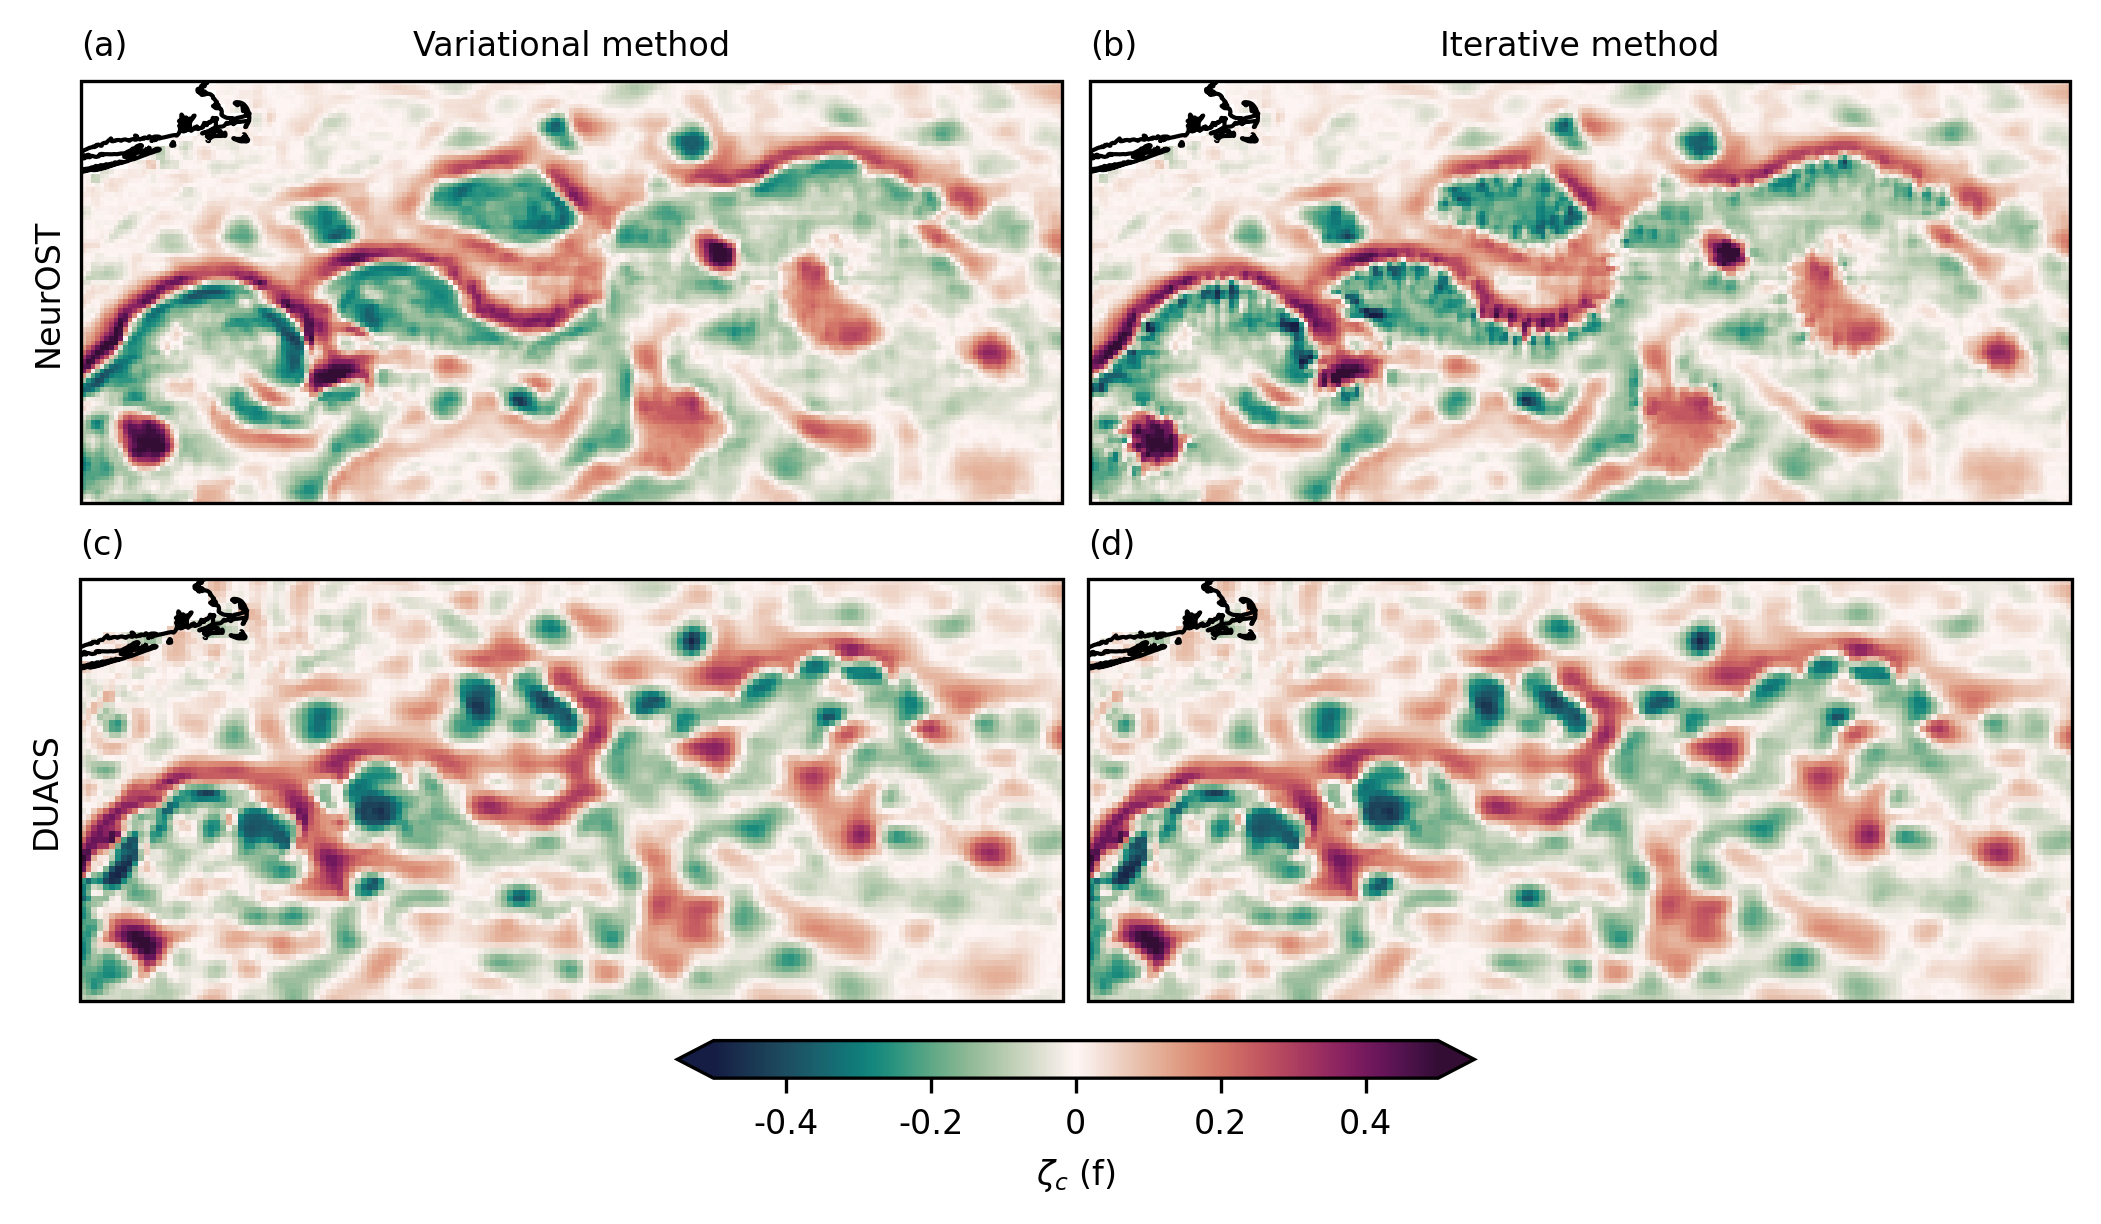

In [22]:
n_rows = 2
n_cols = 2
fig_width = MAX_WIDTH
fig_height = min(
    ((fig_width - HW_SPACE * (n_cols - 1)) / n_cols * PLOT_GS_HW_RATIO + TITLE_H) * n_rows + 
    HW_SPACE * (n_rows - 1) + CLB_AXIS_HW + CLB_HW_SPACE + TITLE_H
    ,
    MAX_HEIGHT
)

fig, axd = plt.subplot_mosaic(
    """
    AB
    CD
    """,
    subplot_kw=dict(projection=ccrs.PlateCarree()),
    gridspec_kw=get_gridspec_kwargs(fig_width, fig_height),
    figsize=(fig_width, fig_height), dpi=DPI, layout="compressed"
)

im = axd["A"].pcolormesh(
    neurost_snapshot_zoom.longitude, neurost_snapshot_zoom.latitude, 
    neurost_snapshot_zoom.nrv_Cyclogeostrophy,
    cmap=cmo.curl, vmin=-NRV_MAX, vmax=NRV_MAX,
    transform=ccrs.PlateCarree()
)
axd["A"].coastlines()
axd["A"].set_title("(a)", loc="left", fontsize=SMALL_FONT_SIZE)
axd["A"].set_title("Variational method", fontsize=SMALL_FONT_SIZE)
axd["A"].set_ylabel("NeurOST", fontsize=SMALL_FONT_SIZE)
axd["A"].set_yticks([])

im = axd["B"].pcolormesh(
    neurost_it_snapshot_zoom.longitude, neurost_it_snapshot_zoom.latitude, 
    neurost_it_snapshot_zoom.nrv_Cyclogeostrophy,
    cmap=cmo.curl, vmin=-NRV_MAX, vmax=NRV_MAX,
    transform=ccrs.PlateCarree()
)
axd["B"].coastlines()
axd["B"].set_title("(b)", loc="left", fontsize=SMALL_FONT_SIZE)
axd["B"].set_title("Iterative method", fontsize=SMALL_FONT_SIZE)

im = axd["C"].pcolormesh(
    duacs_snapshot_zoom.longitude, duacs_snapshot_zoom.latitude, 
    duacs_snapshot_zoom.nrv_Cyclogeostrophy,
    cmap=cmo.curl, vmin=-NRV_MAX, vmax=NRV_MAX,
    transform=ccrs.PlateCarree()
)
axd["C"].coastlines()
axd["C"].set_title("(c)", loc="left", fontsize=SMALL_FONT_SIZE)
axd["C"].set_ylabel("DUACS", fontsize=SMALL_FONT_SIZE)
axd["C"].set_yticks([])

im = axd["D"].pcolormesh(
    duacs_it_snapshot_zoom.longitude, duacs_it_snapshot_zoom.latitude, 
    duacs_it_snapshot_zoom.nrv_Cyclogeostrophy,
    cmap=cmo.curl, vmin=-NRV_MAX, vmax=NRV_MAX,
    transform=ccrs.PlateCarree()
)
axd["D"].coastlines()
axd["D"].set_title("(d)", loc="left", fontsize=SMALL_FONT_SIZE)

clb = fig.colorbar(
    im, ax=axd.values(),
    **get_clb_kwargs(fig_width, fig_height, clb_location="bottom", clb_shrink=.4), 
    extend="both"
)
clb.set_label(label="$\\zeta_c$ (f)", size=SMALL_FONT_SIZE)
tick_labels = [-0.4, -0.2 , 0, 0.2, 0.4]
clb.set_ticks(tick_labels)
clb.set_ticklabels(tick_labels, fontsize=SMALL_FONT_SIZE)

plt.savefig(f"{FIGURES_PATH}/f02.png", dpi=DPI, bbox_inches="tight")

plt.show()

# Cyclogeostrophic imbalance - Figure 3

In [10]:
neurost_imbalance_uv_Geostrophy = xr.open_dataset(f"{DATA_FILES_PATH}/neurost_imbalance_uv_Geostrophy.nc")
neurost_imbalance_uv_Cyclogeostrophy = xr.open_dataset(f"{DATA_FILES_PATH}/neurost_imbalance_uv_Cyclogeostrophy.nc")
neurost_it_imbalance_uv_Cyclogeostrophy = xr.open_dataset(
    f"{DATA_FILES_PATH}/neurost_it_imbalance_uv_Cyclogeostrophy.nc"
)

In [23]:
IMBALANCE_UV_MAX = 1.5


def plot_uv_imbalance(
    uv_imbalance: xr.DataArray, latitude: xr.DataArray, longitude: xr.DataArray, title: str, label: str, ax: GeoAxes
):
    im = ax.pcolormesh(
        longitude, latitude, uv_imbalance,
        cmap=cmo.amp, vmin=0, vmax=IMBALANCE_UV_MAX,
        transform=ccrs.PlateCarree()
    )
    ax.coastlines()

    ax.set_title(title, fontsize=SMALL_FONT_SIZE)
    ax.set_title(label, loc="left", fontsize=SMALL_FONT_SIZE)

    return im
    

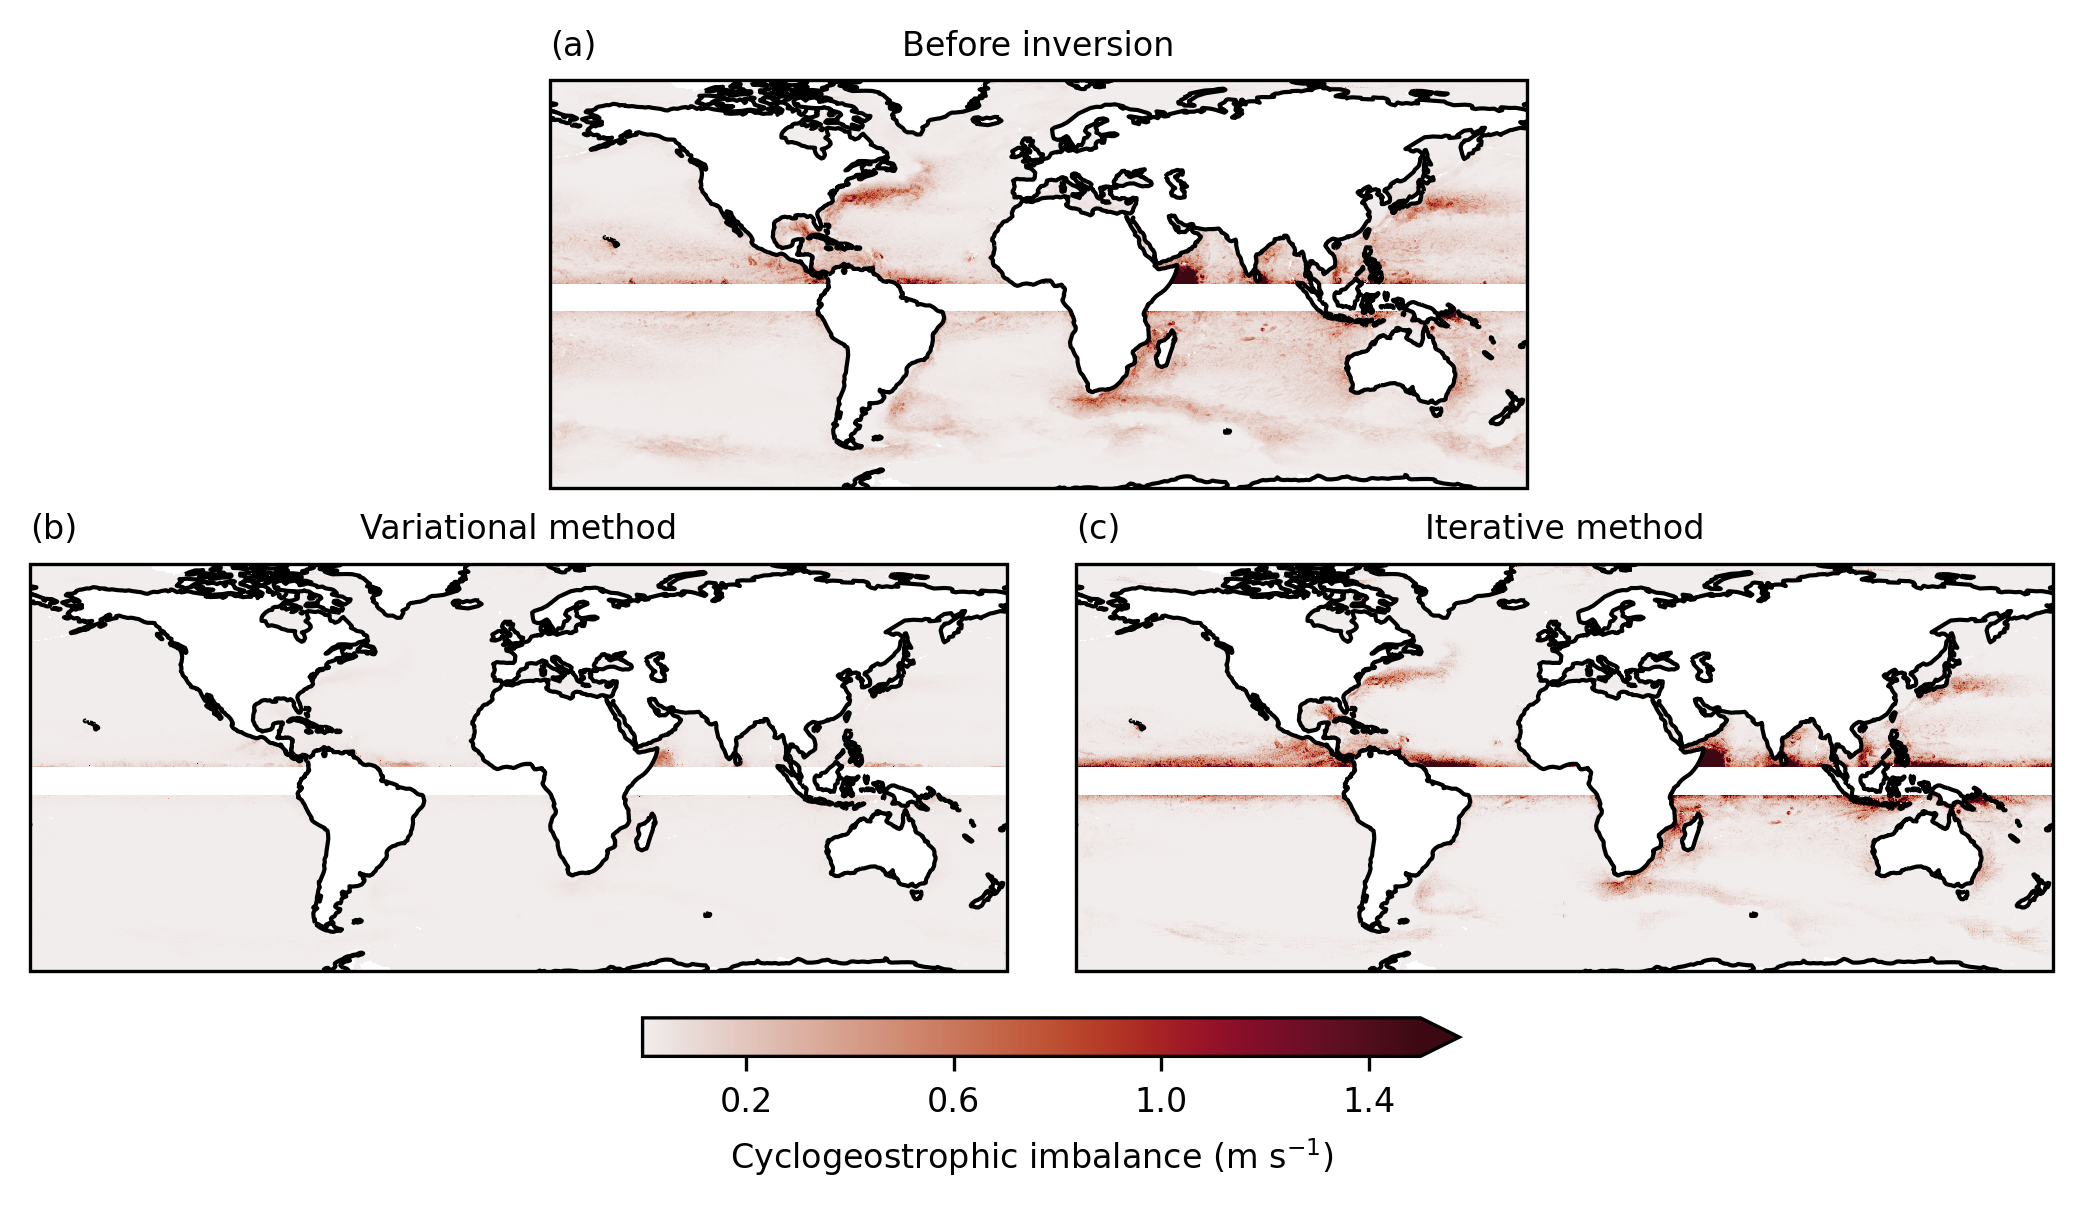

In [24]:
n_rows = 2
n_cols = 2
fig_width = MAX_WIDTH
fig_height = min(
    (
        ((fig_width - HW_SPACE * (n_cols - 1)) / n_cols * PLOT_NEUROST_GLOBAL_HW_RATIO + TITLE_H) * n_rows + 
        HW_SPACE * (n_rows - 1) + CLB_AXIS_HW + CLB_HW_SPACE * 5
    ),
    MAX_HEIGHT
)

fig, axd = plt.subplot_mosaic(
    """
    ..AAAA..
    BBBBCCCC
    """,
    subplot_kw=dict(projection=ccrs.PlateCarree()),
    gridspec_kw=get_gridspec_kwargs(fig_width, fig_height),
    figsize=(fig_width, fig_height), dpi=DPI, layout="compressed"
)

im = plot_uv_imbalance(
    neurost_imbalance_uv_Geostrophy.imbalance_uv_Geostrophy,
    neurost_imbalance_uv_Geostrophy.latitude, neurost_imbalance_uv_Geostrophy.longitude,
    "Before inversion", "(a)",
    axd["A"]
)

_ = plot_uv_imbalance(
    neurost_imbalance_uv_Cyclogeostrophy.imbalance_uv_Cyclogeostrophy,
    neurost_imbalance_uv_Cyclogeostrophy.latitude, neurost_imbalance_uv_Cyclogeostrophy.longitude,
    "Variational method", "(b)",
    axd["B"]
)

_ = plot_uv_imbalance( 
    neurost_it_imbalance_uv_Cyclogeostrophy.imbalance_uv_Cyclogeostrophy,
    neurost_it_imbalance_uv_Cyclogeostrophy.latitude, neurost_it_imbalance_uv_Cyclogeostrophy.longitude,
    "Iterative method", "(c)",
    axd["C"]
)

clb = fig.colorbar(
    im, ax=axd.values(), 
    **get_clb_kwargs(fig_width, fig_height, clb_location="bottom", clb_shrink=.4), 
    extend="max"
)
clb.set_label(label="Cyclogeostrophic imbalance (m s$^{-1}$)", size=SMALL_FONT_SIZE)
tick_labels = [0.2, 0.6 , 1.0, 1.4]
clb.set_ticks(tick_labels)
clb.set_ticklabels(tick_labels, fontsize=SMALL_FONT_SIZE)

plt.savefig(f"{FIGURES_PATH}/f03.png", dpi=DPI, bbox_inches="tight")

plt.show()

# EKE gain / loss - Figure 4

In [13]:
neurost_eke_diff_rel_Cyclogeostrophy_Geostrophy = xr.open_dataset(
    f"{DATA_FILES_PATH}/neurost_eke_diff_rel_Cyclogeostrophy_Geostrophy.nc"
)

In [14]:
EKE_DIFF_REL_MAX = 20

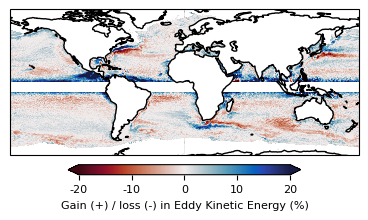

In [15]:
fig_width = MAX_WIDTH * .66
fig_height = min(fig_width * PLOT_NEUROST_GLOBAL_HW_RATIO + CLB_AXIS_HW + CLB_HW_SPACE, MAX_HEIGHT)

fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(fig_width, fig_height))

im = ax.pcolormesh(
    neurost_eke_diff_rel_Cyclogeostrophy_Geostrophy.longitude, neurost_eke_diff_rel_Cyclogeostrophy_Geostrophy.latitude, 
    neurost_eke_diff_rel_Cyclogeostrophy_Geostrophy.eke_diff_rel_Cyclogeostrophy_Geostrophy,
    cmap=cmo.balance_r, vmin=-EKE_DIFF_REL_MAX, vmax=EKE_DIFF_REL_MAX,
    transform=ccrs.PlateCarree()
)
ax.coastlines()

clb = fig.colorbar(
    im, ax=ax, 
    **get_clb_kwargs(fig_width, fig_height, clb_location="bottom", clb_shrink=.66), 
    extend="both"
)
clb.set_label(label="Gain (+) / loss (-) in Eddy Kinetic Energy (%)", size=SMALL_FONT_SIZE)
tick_labels = [-20, -10, 0, 10, 20]
clb.set_ticks(tick_labels)
clb.set_ticklabels(tick_labels, fontsize=SMALL_FONT_SIZE)

plt.savefig(f"{FIGURES_PATH}/f04.png", dpi=DPI, bbox_inches="tight")

plt.show()

# RMSE gain / loss - Figure 5

In [16]:
neurost_spatial_binned_errors_ds = xr.open_dataset(
    f"{DATA_FILES_PATH}/neurost_spatial_binned_errors_ds.nc"
)
duacs_spatial_binned_errors_ds = xr.open_dataset(
    f"{DATA_FILES_PATH}/duacs_spatial_binned_errors_ds.nc"
)

In [17]:
neurost_rmse_gain_loss = (
    neurost_spatial_binned_errors_ds.err_Geostrophy_sd - neurost_spatial_binned_errors_ds.err_Cyclogeostrophy_sd
) / neurost_spatial_binned_errors_ds.err_Geostrophy_sd * 100

duacs_neurost_rmse_gain_loss = (
    duacs_spatial_binned_errors_ds.err_Geostrophy_sd - neurost_spatial_binned_errors_ds.err_Cyclogeostrophy_sd
) / duacs_spatial_binned_errors_ds.err_Geostrophy_sd * 100

duacs_rmse_gain_loss = (
    duacs_spatial_binned_errors_ds.err_Geostrophy_sd - duacs_spatial_binned_errors_ds.err_Cyclogeostrophy_sd
) / duacs_spatial_binned_errors_ds.err_Geostrophy_sd * 100

In [25]:
RMSE_DIFF_REL_MAX = 20


def plot_sd_diff(
    sd_diff: xr.DataArray, latitude: xr.DataArray, longitude: xr.DataArray, title: str, label: str, ax: GeoAxes
):
    im = ax.pcolormesh(
        longitude, latitude, sd_diff,
        cmap=cmo.balance_r, vmin=-RMSE_DIFF_REL_MAX, vmax=RMSE_DIFF_REL_MAX,
        transform=ccrs.PlateCarree()
    )
    ax.coastlines()

    ax.set_title(title, fontsize=SMALL_FONT_SIZE)
    ax.set_title(label, loc="left", fontsize=SMALL_FONT_SIZE)

    return im

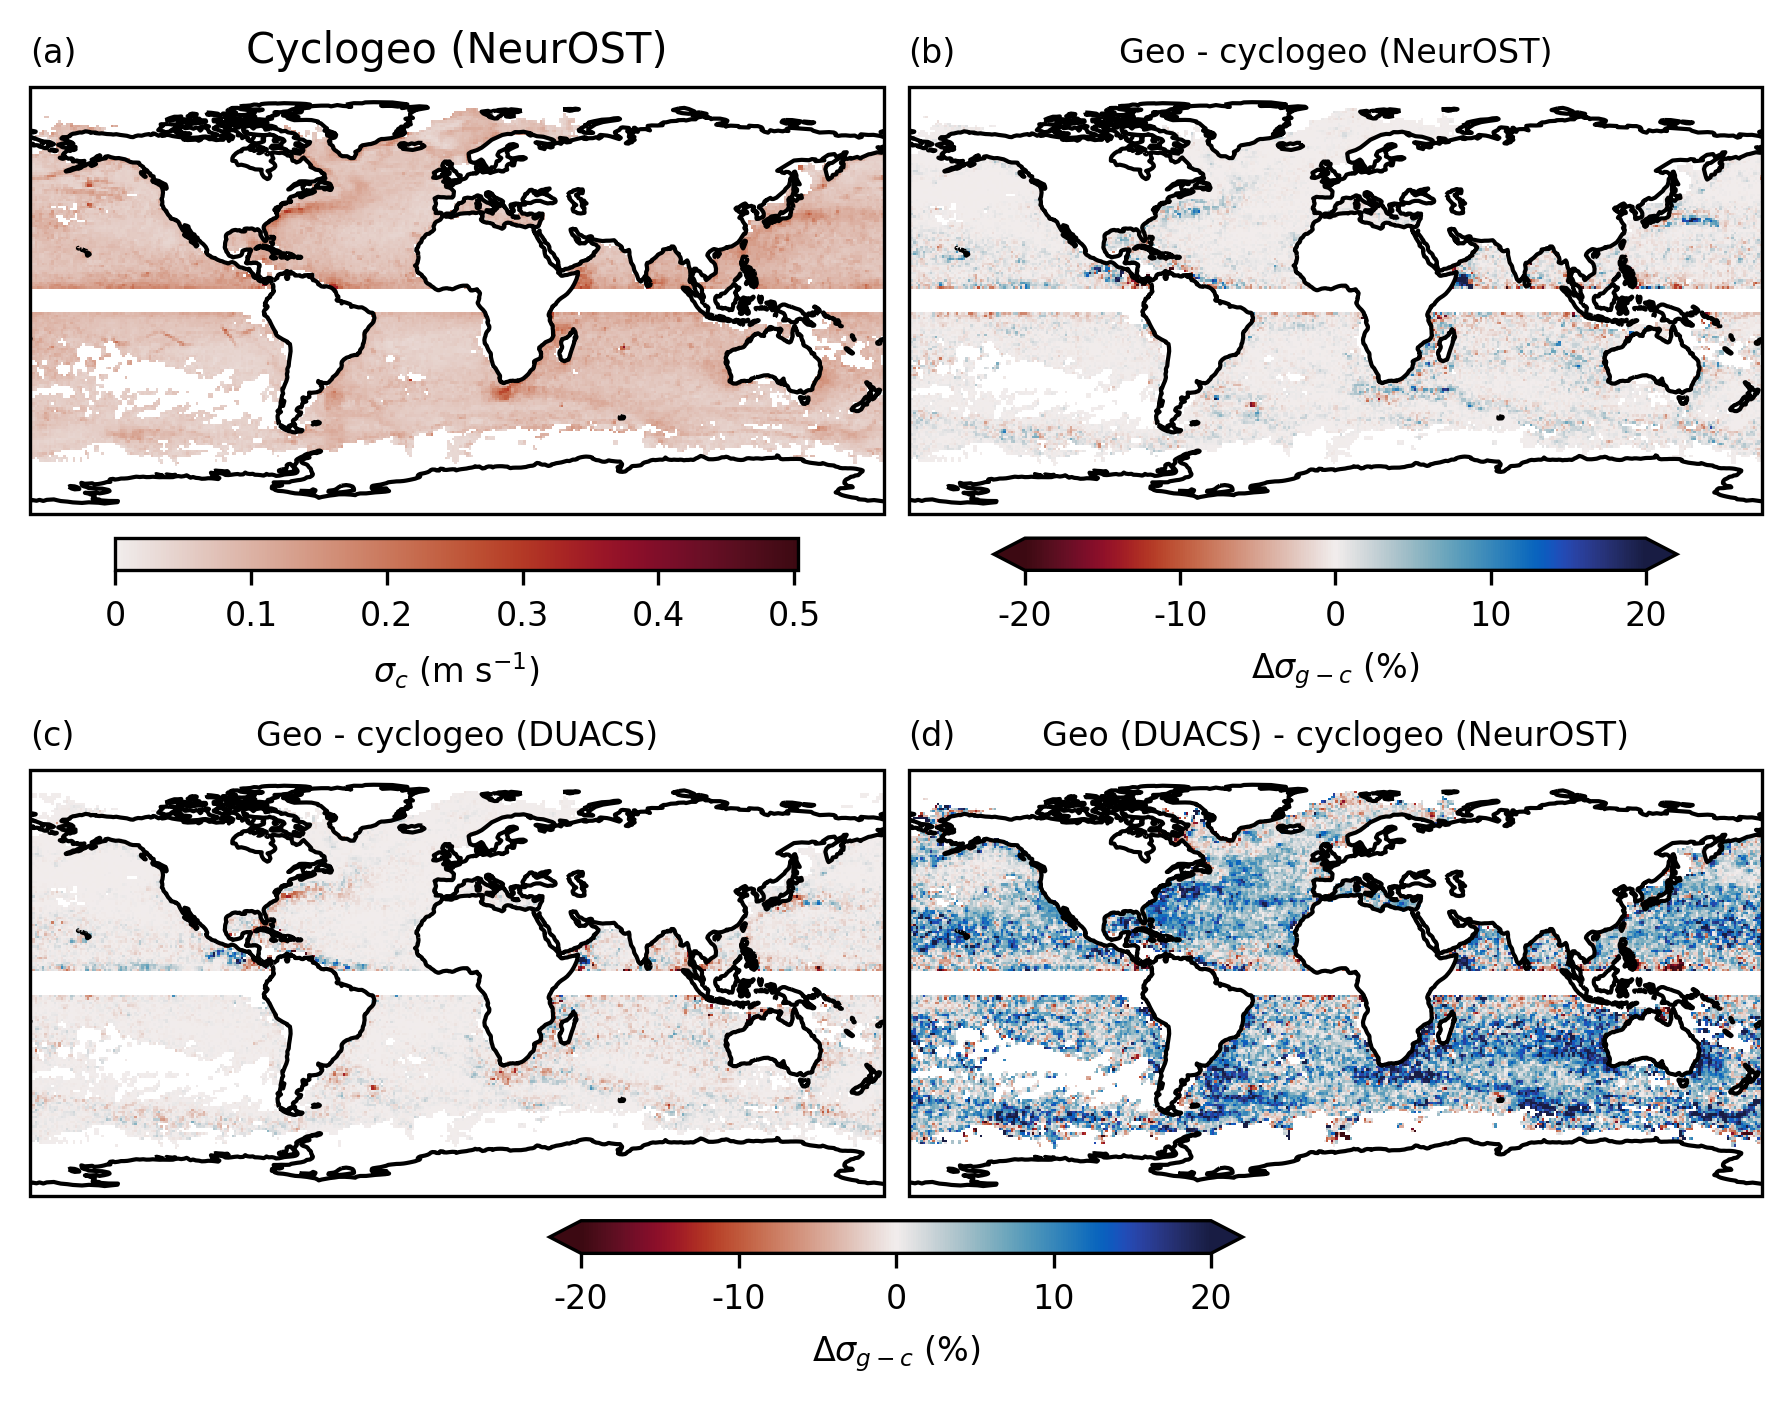

In [26]:
n_rows = 2
n_cols = 2
fig_width = MAX_WIDTH
fig_height = min(
    (
        ((fig_width - HW_SPACE * (n_cols - 1)) / n_cols * PLOT_NEUROST_GLOBAL_HW_RATIO + TITLE_H) * n_rows + 
        HW_SPACE * (n_rows - 1) + (CLB_AXIS_HW + CLB_HW_SPACE) * n_rows
    ),
    MAX_HEIGHT
)

fig, axd = plt.subplot_mosaic(
    """
    AB
    CD
    """,
    subplot_kw=dict(projection=ccrs.PlateCarree()),
    gridspec_kw=get_gridspec_kwargs(fig_width, fig_height),
    figsize=(fig_width, fig_height), dpi=DPI, layout="compressed"
)

im_sd = axd["A"].pcolormesh(
    neurost_spatial_binned_errors_ds.longitude, neurost_spatial_binned_errors_ds.latitude, 
    neurost_spatial_binned_errors_ds.err_Cyclogeostrophy_sd,
    cmap=cmo.amp, vmin=0,
    transform=ccrs.PlateCarree()
)
axd["A"].coastlines()
axd["A"].set_title("Cyclogeo (NeurOST)", fontsize=MEDIUM_FONT_SIZE)
axd["A"].set_title("(a)", loc="left", fontsize=SMALL_FONT_SIZE)

clb_sd = fig.colorbar(
    im_sd, ax=axd["A"], 
    **get_clb_kwargs(fig_width / 2, fig_height / 2, clb_location="bottom", clb_shrink=.8)
)
clb_sd.set_label(label="$\sigma_c$ (m s$^{-1}$)", size=SMALL_FONT_SIZE)
tick_labels = [0, .1, .2, .3, .4, .5]
clb_sd.set_ticks(tick_labels)
clb_sd.set_ticklabels(tick_labels, fontsize=SMALL_FONT_SIZE)

im_sd_diff = plot_sd_diff(
    neurost_rmse_gain_loss,
    neurost_spatial_binned_errors_ds.latitude, neurost_spatial_binned_errors_ds.longitude,
    "Geo - cyclogeo (NeurOST)",
    "(b)",
    axd["B"]
)

clb_sd_diff1 = fig.colorbar(
    im_sd_diff, ax=axd["B"],
    **get_clb_kwargs(fig_width / 2, fig_height / 2, clb_location="bottom", clb_shrink=.8), 
    extend="both"
)
clb_sd_diff1.set_label(label="$\Delta\sigma_{g-c}$ (%)", size=SMALL_FONT_SIZE)
tick_labels = [-20, -10, 0, 10, 20]
clb_sd_diff1.set_ticks(tick_labels)
clb_sd_diff1.set_ticklabels(tick_labels, fontsize=SMALL_FONT_SIZE)

_ = plot_sd_diff(
    duacs_rmse_gain_loss,
    neurost_spatial_binned_errors_ds.latitude, neurost_spatial_binned_errors_ds.longitude,
    "Geo - cyclogeo (DUACS)",
    "(c)",
    axd["C"]
)

_ = plot_sd_diff(
    duacs_neurost_rmse_gain_loss,
    neurost_spatial_binned_errors_ds.latitude, neurost_spatial_binned_errors_ds.longitude,
    "Geo (DUACS) - cyclogeo (NeurOST)",
    "(d)",
    axd["D"]
)

clb_sd_diff2 = fig.colorbar(
    im_sd_diff, ax=list(axd.values())[2:],
    **get_clb_kwargs(fig_width, fig_height / 2, clb_location="bottom", clb_shrink=.4), 
    extend="both"
)
clb_sd_diff2.set_label(label="$\Delta\sigma_{g-c}$ (%)", size=SMALL_FONT_SIZE)
tick_labels = [-20, -10, 0, 10, 20]
clb_sd_diff2.set_ticks(tick_labels)
clb_sd_diff2.set_ticklabels(tick_labels, fontsize=SMALL_FONT_SIZE)

plt.savefig(
    f"{FIGURES_PATH}/f05.png", dpi=DPI, bbox_inches="tight"
)

plt.show()

# RMSE / EKE - Figure 6

In [20]:
neurost_eke_binned_errors = xr.open_dataset(f"{DATA_FILES_PATH}/neurost_eke_binned_errors.nc")
duacs_eke_binned_errors = xr.open_dataset(f"{DATA_FILES_PATH}/duacs_eke_binned_errors.nc")
neurost_it_eke_binned_errors = xr.open_dataset(f"{DATA_FILES_PATH}/neurost_it_eke_binned_errors.nc")
duacs_it_eke_binned_errors = xr.open_dataset(f"{DATA_FILES_PATH}/duacs_it_eke_binned_errors.nc")

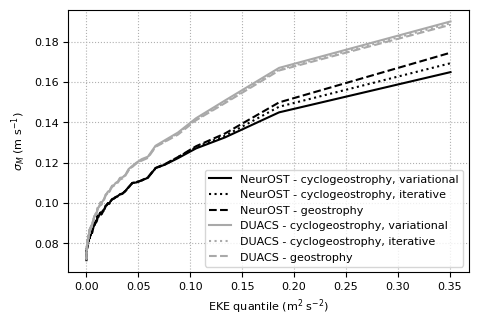

In [21]:
fig, ax = plt.subplots(figsize=(MAX_WIDTH * .75, MAX_WIDTH * .75 * .66))

ax.plot(
    neurost_eke_binned_errors.eke, neurost_eke_binned_errors.err_sd_Cyclogeostrophy, 
    color="k", linestyle="-",
    label="NeurOST - cyclogeostrophy, variational"
)
ax.plot(
    neurost_it_eke_binned_errors.eke, neurost_it_eke_binned_errors.err_sd_Cyclogeostrophy, 
    color="k", linestyle=":",
    label="NeurOST - cyclogeostrophy, iterative"
)
ax.plot(
    neurost_eke_binned_errors.eke, neurost_eke_binned_errors.err_sd_Geostrophy, 
    color="k", linestyle="--",
    label="NeurOST - geostrophy"
)
ax.plot(
    duacs_eke_binned_errors.eke, duacs_eke_binned_errors.err_sd_Cyclogeostrophy, 
    color="darkgrey", linestyle="-",
    label="DUACS - cyclogeostrophy, variational"
)
ax.plot(
    duacs_it_eke_binned_errors.eke, duacs_it_eke_binned_errors.err_sd_Cyclogeostrophy, 
    color="darkgrey", linestyle=":",
    label="DUACS - cyclogeostrophy, iterative"
)
ax.plot(
    duacs_eke_binned_errors.eke, duacs_eke_binned_errors.err_sd_Geostrophy, 
    color="darkgrey", linestyle="--",
    label="DUACS - geostrophy"
)

plt.grid(True, linestyle=':')

ax.legend()

ax.set_xlabel("EKE quantile (m$^2$ s$^{-2}$)", size=SMALL_FONT_SIZE)
ax.set_ylabel("$\sigma_M$ (m s$^{-1}$)", size=SMALL_FONT_SIZE)

plt.savefig(f"{FIGURES_PATH}/f06.png", dpi=DPI, bbox_inches="tight")

plt.show()